## Set up
### Importing libraries

In [21]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from itertools import combinations

### Data load & enrichment

In [2]:
data_folder = '.'

additional_features = pd.read_csv(f"{data_folder}/data.csv").drop("Id", axis=1)
additional_features = additional_features.fillna(additional_features.mean())
additional_features = additional_features.fillna('N/A')
base_features = pd.read_csv(f"{data_folder}/Houseprice_data_scaled.csv")

### Parameters & Constants

In [134]:
# Params
SHOW_CAT_TO_NUM_WARNING = False
ADDITIONAL_FEATURES_SELECT = ['ScreenPorch', 'MasVnrArea']
LAMBDA_RIDGE = 0.1
LAMBDA_LASSO = 0.04
N_SIMULATIONS = 10

# Constants
ADDITIONAL_FEATURES_FIXED = ['LotFrontage', 'LotShape']
ADDITIONAL_FEATURES = ADDITIONAL_FEATURES_FIXED + ADDITIONAL_FEATURES_SELECT

### Helper functions

In [29]:
def add_features(base, feature_name):
    """ 
    Outputs a dataframe which equals base_features plus any feature_name from additional_features. 
    Any categorical features will be naively converts to numerical values. All the feature values will be scaled.
    Any missing values (N/A) are filled with average values for this feature
    """
    rep_base = base.copy()
    def add_single_feature(single_feature):
        if is_numeric_dtype(additional_features[single_feature].dtype):
            rep_base[single_feature] = additional_features[single_feature]
        else:
            flist = np.setdiff1d(additional_features[single_feature].unique(), ['N/A'])
            f_map = dict(zip(flist, range(len(flist))))
            if SHOW_CAT_TO_NUM_WARNING:
                print("Warning: feature {} is categorical. Mapping to numerical...".format(single_feature))
                print("Mapping: {}".format(f_map))    
            rep_base[single_feature] = additional_features[single_feature].map(f_map)
            # TODO: what to do for NA in categorical features?
            rep_base[single_feature] = rep_base[single_feature].replace('N/A', np.nan)
            rep_base[single_feature] = rep_base[single_feature].fillna(rep_base[single_feature].mean())
        rep_base[single_feature] = (rep_base[single_feature] - rep_base[single_feature].mean()) / rep_base[single_feature].std()
    if type(feature_name) == str:
        add_single_feature(feature_name)
    else:
        for f in feature_name:
            add_single_feature(f)
    return rep_base

def split_dataset(dataset, random=False):
    """ Split input dataset into training, validation and test set (in this order) of size 1800, 600 and whatever left """
    idx_lst = np.arange(len(dataset))
    if random:
        np.random.shuffle(idx_lst)
    train_idx = idx_lst[:1800]
    val_idx = idx_lst[1800:1800+600]
    test_idx = idx_lst[1800+600:len(dataset)]
    return dataset.iloc[train_idx], dataset.iloc[val_idx], dataset.iloc[test_idx]

def split_xy(dataset, value_name="Sale Price"):
    """ Split input data set into feature and value """
    return dataset.drop(value_name, axis=1), dataset[[value_name]]

def regression(features, method='linear', alpha=0, random=False):
    """ 
    Run a regression of choice with additional features added to base_features
    
    :param features: A list of features available in dataframe additional_features
    :param method: One of "linear", "ridge" or "lasso"
    :param alpha: Alpha pamameter used for ridge or lasso regression. Should be lambda in Hull's book times # of 
                  observations for ridge regression or half of lambda for lasso regression.
    :param random: Whether to split training/validation/test data sets randomly or not
    
    :return: A dictionary containing coeffients and model mse
    """
    # Select features
    df = add_features(base_features, ADDITIONAL_FEATURES_FIXED + list(features))
    
    # Split data set and split each into X and y where y is the price, and X is set of features
    train, val, test = [split_xy(x) for x in split_dataset(df, random=random)]
    
    # Fit model
    def fit_model(alpha):
        reg_model = {
            'linear': LinearRegression(),
            'ridge': Ridge(alpha=alpha),
            'lasso': Lasso(alpha=alpha),
        }[method.lower()]
        reg_model.fit(*train)
    
        return {
            'coeffs': pd.DataFrame(
                [
                    ['intercept'] + list(train[0]),
                    list(reg_model.intercept_) + list(reg_model.coef_ if method == 'lasso' else reg_model.coef_[0])
                ]
            ).transpose().set_index(0),
            'mse': mse(val[1], reg_model.predict(val[0])),
        }
    
    try:
        return fit_model(float(alpha))
    except TypeError:
        return [fit_model(float(a)) for a in alpha]

def monte_carlo(features, n_simulations, method="linear", alpha=0):
    """
    Run Monte Carlo simulations for a particular regression method and output the average mses and coeffs
    """
    def mc_single_alpha(features, n_simulations, method, alpha):
        coeffs = []
        mses = []
        for i in range(n_simulations):
            rs = regression(features, method=method, alpha=alpha, random=True)
            coeffs.append(rs['coeffs'])
            mses.append(rs['mse'])    
        return {
            'coeffs': pd.DataFrame(pd.concat(coeffs, axis=1).mean(axis=1)),
            'mse': np.array(mses).mean(),
        }
    try:
        return mc_single_alpha(features, n_simulations, method, float(alpha))
    except TypeError:
        return [mc_single_alpha(features, n_simulations, method, float(a)) for a in alpha]

## Feature Selections
For a fixed alpha level, select two features that minimizes mse using either linear, ridge or lasso regression

In [73]:
res = {}
for feature_pair in list(combinations(set(additional_features.columns) - set(['SalePrice']), 2)):
    res[frozenset(feature_pair)] = regression(feature_pair, method='ridge', alpha=LAMBDA_RIDGE*1800, random=False)['mse']

In [97]:
fdf = pd.concat([pd.DataFrame([[*x] for x in list(res.keys())]), pd.DataFrame(res.values())], axis=1)
fdf.columns = ['feature 1', 'feature 2', 'mse']
fdf = fdf.sort_values(by='mse')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fdf)

          feature 1      feature 2       mse
2994       BsmtQual      ExterQual  0.093391
1356      ExterQual       BldgType  0.094291
2369       BsmtQual    KitchenQual  0.095119
1414     MSSubClass      ExterQual  0.095184
2364      ExterQual    KitchenQual  0.096017
1361       BsmtQual       BldgType  0.096238
1331    KitchenQual       BldgType  0.096494
1419       BsmtQual     MSSubClass  0.097549
2077      ExterQual     MasVnrArea  0.097609
2506   BsmtExposure      ExterQual  0.097777
1389     MSSubClass    KitchenQual  0.097845
2082       BsmtQual     MasVnrArea  0.098648
1176      ExterQual   GarageFinish  0.098716
2602    ScreenPorch      ExterQual  0.098768
3002      ExterQual     Foundation  0.098790
2052    KitchenQual     MasVnrArea  0.098862
217       ExterQual     Functional  0.098874
2976    FireplaceQu      ExterQual  0.098932
1297     GarageQual      ExterQual  0.099263
2791      ExterQual      ExterCond  0.099534
1939   KitchenAbvGr      ExterQual  0.099554
2716      

In [131]:
# Assumes all the features are added. Look at what are the non zero features after lasso
tmp = regression(list(set(additional_features.columns) - set(['SalePrice'])), method='lasso', alpha=LAMBDA_LASSO/2)['coeffs']
ok_features = []
for i in tmp[tmp[1] > 0].index:
    if i in additional_features.columns:
        ok_features.append(i)
for i in fdf.iterrows():
    if i[1]['feature 1'] in ok_features and i[1]['feature 2'] in ok_features:
        print(i)

(2059, feature 1    ScreenPorch
feature 2     MasVnrArea
mse             0.107866
Name: 2059, dtype: object)
(2073, feature 1    SaleCondition
feature 2       MasVnrArea
mse               0.108003
Name: 2073, dtype: object)
(185, feature 1    Functional
feature 2    MasVnrArea
mse            0.108566
Name: 185, dtype: object)
(2046, feature 1    MasVnrArea
feature 2        PoolQC
mse            0.108913
Name: 2046, dtype: object)
(479, feature 1      1stFlrSF
feature 2    MasVnrArea
mse            0.109191
Name: 479, dtype: object)
(1019, feature 1    Fireplaces
feature 2    MasVnrArea
mse            0.109191
Name: 1019, dtype: object)
(2047, feature 1    GarageArea
feature 2    MasVnrArea
mse            0.109191
Name: 2047, dtype: object)
(407, feature 1     MasVnrArea
feature 2    TotalBsmtSF
mse             0.109191
Name: 407, dtype: object)
(1760, feature 1    WoodDeckSF
feature 2    MasVnrArea
mse            0.109191
Name: 1760, dtype: object)
(2064, feature 1    MasVnrArea
featur

(2234, feature 1      LotArea
feature 2    YearBuilt
mse           0.112687
Name: 2234, dtype: object)
(2151, feature 1    GarageArea
feature 2     YearBuilt
mse            0.112687
Name: 2151, dtype: object)
(2152, feature 1      HalfBath
feature 2    GarageArea
mse            0.112687
Name: 2152, dtype: object)
(2168, feature 1    GarageArea
feature 2    GarageCars
mse            0.112687
Name: 2168, dtype: object)
(460, feature 1      1stFlrSF
feature 2    Fireplaces
mse            0.112687
Name: 460, dtype: object)
(409, feature 1     GarageArea
feature 2    TotalBsmtSF
mse             0.112687
Name: 409, dtype: object)
(1762, feature 1    WoodDeckSF
feature 2    GarageArea
mse            0.112687
Name: 1762, dtype: object)
(2730, feature 1     HalfBath
feature 2    YearBuilt
mse           0.112687
Name: 2730, dtype: object)
(388, feature 1     Fireplaces
feature 2    TotalBsmtSF
mse             0.112687
Name: 388, dtype: object)
(498, feature 1     1stFlrSF
feature 2    YearBuilt


Name: 1544, dtype: object)
(1586, feature 1    GarageCars
feature 2    MasVnrType
mse            0.114755
Name: 1586, dtype: object)
(397, feature 1     MasVnrType
feature 2    TotalBsmtSF
mse             0.114755
Name: 397, dtype: object)
(469, feature 1      1stFlrSF
feature 2    MasVnrType
mse            0.114755
Name: 469, dtype: object)
(1592, feature 1    MasVnrType
feature 2     GrLivArea
mse            0.114755
Name: 1592, dtype: object)
(1590, feature 1    OpenPorchSF
feature 2     MasVnrType
mse             0.114755
Name: 1590, dtype: object)
(1556, feature 1    BsmtFinSF1
feature 2    MasVnrType
mse            0.114755
Name: 1556, dtype: object)
(1554, feature 1       LotArea
feature 2    MasVnrType
mse            0.114755
Name: 1554, dtype: object)
(1594, feature 1    OverallCond
feature 2     MasVnrType
mse             0.114755
Name: 1594, dtype: object)
(1195, feature 1      MasVnrType
feature 2    YearRemodAdd
mse              0.114755
Name: 1195, dtype: object)
(747, fe

## Regression Analysis I

Use first 1800 as training set, next 800 as validation set and the rest as test set  

### Linear Regression

In [135]:
regression(ADDITIONAL_FEATURES_SELECT, method='linear')['coeffs']

,1
0,
intercept,-0.0128812
LotArea,0.0621072
OverallQual,0.209273
OverallCond,0.0952927
YearBuilt,0.164629
YearRemodAdd,0.0309044
BsmtFinSF1,0.0867431
BsmtUnfSF,-0.0340884
TotalBsmtSF,0.134773


### Ridge Regression

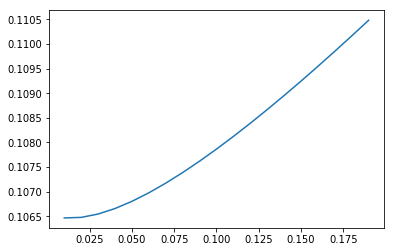

,1
0,
intercept,-0.0132735
LotArea,0.0572286
OverallQual,0.188808
OverallCond,0.0748865
YearBuilt,0.104348
YearRemodAdd,0.0502649
BsmtFinSF1,0.0984614
BsmtUnfSF,-0.0167653
TotalBsmtSF,0.104955


In [136]:
lambdas = np.arange(0.01, 0.2, 0.01)
alphas = lambdas * 1800

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES_SELECT, method='ridge', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES_SELECT, method='ridge', alpha=LAMBDA_RIDGE*1800)['coeffs']

### Lasso Regression

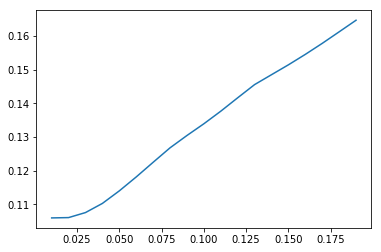

,1
0,
intercept,-0.0134012
LotArea,0.0552491
OverallQual,0.252176
OverallCond,0.0459705
YearBuilt,0.10127
YearRemodAdd,0.0551169
BsmtFinSF1,0.115443
BsmtUnfSF,-0
TotalBsmtSF,0.099492


In [137]:
lambdas = np.arange(0.01, 0.2, 0.01)
alphas = lambdas / 2

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES_SELECT, method='lasso', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES_SELECT, method='lasso', alpha=LAMBDA_LASSO/2)['coeffs']


## Regression Analysis II

Randomly determine training set, validation set and test set  
TODO: MONTE CARLO THIS SHIT!

### Linear Regression

In [138]:
monte_carlo(ADDITIONAL_FEATURES_SELECT, N_SIMULATIONS, method='linear')['coeffs']

,0
0,
intercept,4.537470e-03
LotArea,6.498825e-02
OverallQual,2.169347e-01
OverallCond,8.553138e-02
YearBuilt,1.633718e-01
YearRemodAdd,3.961651e-02
BsmtFinSF1,7.294542e-02
BsmtUnfSF,-5.445025e-02
TotalBsmtSF,1.506179e-01


### Ridge Regression

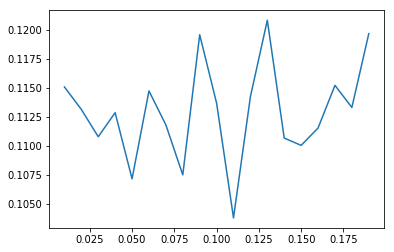

,0
0,
intercept,-0.000723
LotArea,0.060914
OverallQual,0.193359
OverallCond,0.069430
YearBuilt,0.102618
YearRemodAdd,0.059154
BsmtFinSF1,0.096152
BsmtUnfSF,-0.027910
TotalBsmtSF,0.104536


In [139]:
lambdas = np.arange(0.01, 0.2, 0.01)
alphas = lambdas * 1800

mses = [x['mse'] for x in monte_carlo(ADDITIONAL_FEATURES_SELECT, N_SIMULATIONS, method='ridge', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

monte_carlo(ADDITIONAL_FEATURES_SELECT, N_SIMULATIONS, method='ridge', alpha=LAMBDA_RIDGE*1800)['coeffs']

### Lasso Regression

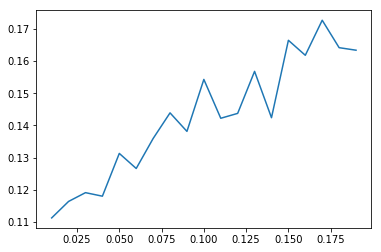

,0
0,
intercept,0.001547
LotArea,0.053756
OverallQual,0.262889
OverallCond,0.036039
YearBuilt,0.086498
YearRemodAdd,0.063235
BsmtFinSF1,0.116495
BsmtUnfSF,-0.000000
TotalBsmtSF,0.085014


In [140]:
lambdas = np.arange(0.01, 0.2, 0.01)
alphas = lambdas / 2

mses = [x['mse'] for x in monte_carlo(ADDITIONAL_FEATURES_SELECT, N_SIMULATIONS, method='lasso', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

monte_carlo(ADDITIONAL_FEATURES_SELECT, N_SIMULATIONS, method='lasso', alpha=LAMBDA_LASSO/2)['coeffs']

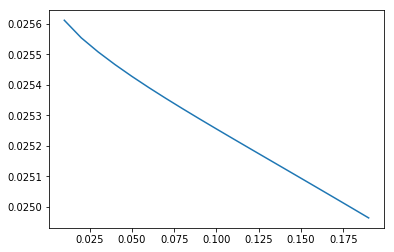

In [76]:
# Yvonne's for loop

lambdas = np.arange(0.01, 0.2, 0.01)
alphas = lambdas * 1800

plt.plot(lambdas, [float(shit['coeffs'].mean()) for shit in regression(ADDITIONAL_FEATURES_SELECT, method='ridge', alpha=alphas)])
plt.show()